# QNN - Initial draft

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ketbra}[2]{\left|{#1}\middle\rangle\langle{#2}\right|}
$$


In [11]:
import sys
stdout = sys.stdout
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_vector

import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')


As shown in the previous two chapters, we have evaluated that the creation of quantum circuits to emulate binary addition and multiplication. While feasible, and a possible solution for future _Q-CPU_-only devices, if they ever come, their large growth makes them, currently, unable to efficiently emulate classical neurons from machine learning. 

To start, we will take a look at the proposed model shown by _Tacchino et al.[1](https://doi.org/10.1038/s41534-019-0140-4)_ and compare it to a classical model built with _(PyTorch)[https://pytorch.org/]_. For the purpose of comparison, we will use the simple _[IRIS-Dataset]()_

## Initial data analysis

To begin with, we will take a look at the dataset that is contained in `sklearn`.

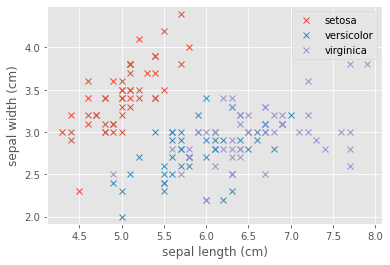

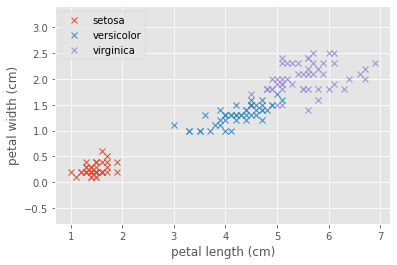

In [12]:
from sklearn.datasets import load_iris


# Load the data and split it up into usable chunks
dataset = load_iris()
data = dataset['data']
data_target = dataset['target']
target_names = dataset['target_names']
feature_names = dataset['feature_names']

for i in range(0,3,2):
    figure, axis = plt.subplots()
    for target, target_name in enumerate(target_names):
        X_plot = data[data_target == target]
        axis.plot(X_plot[:, i], X_plot[:, i+1], 
                linestyle='none', 
                marker='x', 
                label=target_name)
    axis.set_xlabel(feature_names[i])
    axis.set_ylabel(feature_names[i+1])
    axis.axis('equal')
    axis.legend();

## PyTorch model

In [14]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torchviz import make_dot


#check if we can train on a GPU or if we have to rely on the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In _PyTorch_, we have to create a class of our network so that we can instantate it Here we define a model with 1 input layer, 1 hidden layer and 1 output layer. The activation function from layer 1 to the hidden layer is a _relU_ function, and from the hidden layer to the output layer is a _softmax_ function.

In [27]:
class IrisNetwork(nn.Module):
    def __init__(self):
        super(IrisNetwork, self).__init__()
        self.layer1 = nn.Linear(4, 4)
        self.layer2 = nn.Linear(4, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x

def get_pytorch_model():
    return IrisNetwork().to(device)

When training a model, it is necessary to split the existing data into 2 datasets: testing and training. For this we have to normalize the data beforehand using `sklearn.preprocessing.StandardScaler()` To make the tests reproducible, we also define a _seed_.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Now we normalize the data, this is specially important for the QNN
scaled_data = StandardScaler().fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, data_target, test_size=0.2, random_state=2, seed=69069)

Now to testing. In Pytorch, we need to define the type of variable used in the separate datasets, as right now they are in the numpy format. For example:

_X\_train_ is the input dataset of the 4 attributes. Its format is _long_

In [34]:
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


In [49]:
import tqdm

EPOCHS = 1000
ALPHA = 0.001

loss_over_epochs     = np.zeros((EPOCHS,))
accuracy_over_epochs = np.zeros((EPOCHS,))

model = get_pytorch_model()
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
loss_fn   = nn.CrossEntropyLoss()


for epoch in tqdm.trange(EPOCHS):
    prediction = model(X_train)
    loss = loss_fn(prediction, y_train)
    loss_over_epochs[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_over_epochs[epoch] = correct.mean()

100%|██████████| 1000/1000 [00:01<00:00, 983.10it/s]


Achieved accuravy of: 0.9333333373069763


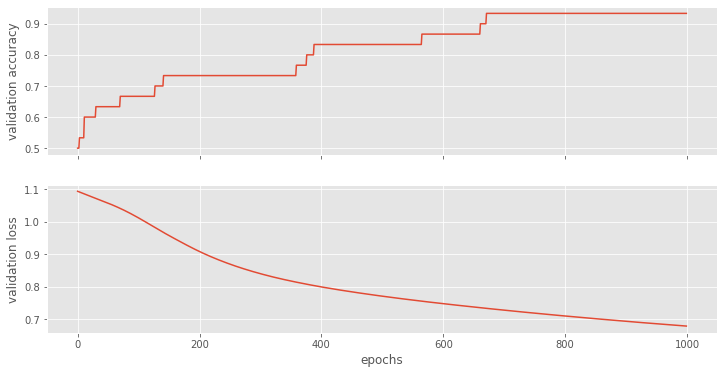

In [50]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_over_epochs)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_over_epochs)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

print('Achieved accuravy of: ' + str(accuracy_list[-1]))

## Qiskit model

We will now try to build an equivalent model using qiskit, based on the purposal by _[Tacchino et al.](https://doi.org/10.1038/s41534-019-0140-4)_.

### Bibliography

[1] Tacchino, F., Macchiavello, C., Gerace, D. et al. An artificial neuron implemented on an actual quantum processor. npj Quantum Inf **5**, 26 (2019). https://doi.org/10.1038/s41534-019-0140-4